# Finetuning FastPitch for a new speaker

In this tutorial, we will finetune a single speaker FastPitch (with alignment) model on 5 mins of a new speaker's data. We will finetune the model parameters only on the new speaker's text and speech pairs (though see the section at the end to learn more about mixing speaker data).

We will download the training data, then generate and run a training command to finetune Fastpitch on 5 mins of data, and synthesize the audio from the trained checkpoint.

A final section will describe approaches to improve audio quality past this notebook.

## License

> Copyright (c) 2021, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.
>
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
>     http://www.apache.org/licenses/LICENSE-2.0
>
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [1]:
"""
You can either run this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
BRANCH = 'main'
# If you're using Google Colab and not running locally, uncomment and run this cell.
!apt-get install sox libsndfile1 ffmpeg
!pip install wget unidecode pynini==2.1.4
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 sox
0 upgraded, 8 newly installed, 0 to remove and 42 not upgraded.
Need to get 760 kB of archives.
After this operation, 6,717 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3

## Downloading data

For our tutorial, we will use a small part of the Hi-Fi Multi-Speaker English TTS (Hi-Fi TTS) dataset. You can read more about dataset [here](https://arxiv.org/abs/2104.01497). We will use speaker 6097 as the target speaker, and only a 5-minute subset of audio will be used for this fine-tuning example. We additionally resample audio to 22050 kHz.

In [2]:
!tar -xzf 6097_5_mins.tar.gz

Looking at `manifest.json`, we see a standard NeMo json that contains the filepath, text, and duration. Please note that our `manifest.json` contains the relative path.

Let's make sure that the entries look something like this:

```
{"audio_filepath": "audio/presentpictureofnsw_02_mann_0532.wav", "text": "not to stop more than ten minutes by the way", "duration": 2.6, "text_no_preprocessing": "not to stop more than ten minutes by the way,", "text_normalized": "not to stop more than ten minutes by the way,"}
```

In [3]:
!head -n 1 ./6097_5_mins/manifest.json

{"audio_filepath": "audio/001.wav", "text": "A well-known scientist once gave a public lecture on astronomy.  He described how the earth orbits around the sun.", "duration": 8}


Let's take 2 samples from the dataset and split it off into a validation set. Then, split all other samples into the training set.

As mentioned, since the paths in the manifest are relative, we also create a symbolic link to the audio folder such that `audio/` goes to the correct directory.

In [4]:
!cat ./6097_5_mins/manifest.json | tail -n 2 > ./6097_manifest_dev_ns_all_local.json
!cat ./6097_5_mins/manifest.json | head -n -2 > ./6097_manifest_train_dur_5_mins_local.json
!ln -s ./6097_5_mins/audio audio

Let's also download the pretrained checkpoint that we want to finetune from. NeMo will save checkpoints to `~/.cache`, so let's move that to our current directory. 

*Note: please, check that `home_path` refers to your home folder. Otherwise, change it manually.*

In [5]:
home_path = !(echo $HOME)
home_path = home_path[0]
print(home_path)

/root


In [6]:
import os
import json

import torch
import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

from nemo.collections.tts.models import FastPitchModel
FastPitchModel.from_pretrained("tts_en_fastpitch")

from pathlib import Path
nemo_files = [p for p in Path(f"{home_path}/.cache/torch/NeMo/").glob("**/tts_en_fastpitch_align.nemo")]
print(f"Copying {nemo_files[0]} to ./")
Path("./tts_en_fastpitch_align.nemo").write_bytes(nemo_files[0].read_bytes())

[NeMo W 2022-05-13 18:08:24 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-05-13 18:08:24 experimental:28] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-05-13 18:08:24 experimental:28] Module <class 'nemo.collections.nlp.models.text_normalization_as_tagging.thutmose_tagger.ThutmoseTaggerModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


[NeMo I 2022-05-13 18:08:25 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_fastpitch/versions/1.8.1/files/tts_en_fastpitch_align.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo
[NeMo I 2022-05-13 18:08:32 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-05-13 18:08:33 tokenize_and_classify:92] Creating ClassifyFst grammars.


[NeMo W 2022-05-13 18:08:51 g2ps:85] apply_to_oov_word=None, it means that some of words will remain unchanged if they are not handled by one of rule in self.parse_one_word(). It is useful when you use tokenizer with set of phonemes and chars together, otherwise it can be not.
[NeMo W 2022-05-13 18:08:51 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /ws/LJSpeech/nvidia_ljspeech_train_clean_ngc.json
      sample_rate: 22050
      sup_data_path: /raid/LJSpeech/supplementary
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: nu

[NeMo I 2022-05-13 18:08:51 features:200] PADDING: 1
[NeMo I 2022-05-13 18:09:04 save_restore_connector:243] Model FastPitchModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo.
Copying /root/.cache/torch/NeMo/NeMo_1.9.0rc0/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo to ./


187023360

To finetune the FastPitch model on the above created filelists, we use the `examples/tts/fastpitch_finetune.py` script to train the models with the `fastpitch_align_v1.05.yaml` configuration.

Let's grab those files.

In [7]:
!wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/fastpitch_finetune.py

!mkdir -p conf \
&& cd conf \
&& wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/fastpitch_align_v1.05.yaml \
&& cd ..

--2022-05-13 18:09:17--  https://raw.githubusercontent.com/nvidia/NeMo/main/examples/tts/fastpitch_finetune.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751 (1.7K) [text/plain]
Saving to: ‘fastpitch_finetune.py’

fastpitch_finetune. 100%[===================>]   1.71K  --.-KB/s    in 0s      

2022-05-13 18:09:17 (21.6 MB/s) - ‘fastpitch_finetune.py’ saved [1751/1751]

--2022-05-13 18:09:17--  https://raw.githubusercontent.com/nvidia/NeMo/main/examples/tts/conf/fastpitch_align_v1.05.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 

We also need some additional files (see `FastPitch_MixerTTS_Training.ipynb` tutorial for more details) for training. Let's download these, too.

In [8]:
# additional files
!mkdir -p tts_dataset_files && cd tts_dataset_files \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/cmudict-0.7b_nv22.01 \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/heteronyms-030921 \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/nemo_text_processing/text_normalization/en/data/whitelist/lj_speech.tsv \
&& cd ..

--2022-05-13 18:09:20--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/scripts/tts_dataset_files/cmudict-0.7b_nv22.01
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3721964 (3.5M) [text/plain]
Saving to: ‘cmudict-0.7b_nv22.01’

cmudict-0.7b_nv22.0 100%[===================>]   3.55M  --.-KB/s    in 0.07s   

2022-05-13 18:09:20 (50.5 MB/s) - ‘cmudict-0.7b_nv22.01’ saved [3721964/3721964]

--2022-05-13 18:09:20--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/scripts/tts_dataset_files/heteronyms-030921
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaitin

## Finetuning FastPitch

We can now train our model with the following command:

**NOTE: This will take about 50 minutes on colab's K80 GPUs.**

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
# TODO(oktai15): remove +model.text_tokenizer.add_blank_at=true when we update FastPitch checkpoint
!(python fastpitch_finetune.py --config-name=fastpitch_align_v1.05.yaml \
  train_dataset=./6097_manifest_train_dur_5_mins_local.json \
  validation_datasets=./6097_manifest_dev_ns_all_local.json \
  sup_data_path=./fastpitch_sup_data \
  phoneme_dict_path=tts_dataset_files/cmudict-0.7b_nv22.01 \
  heteronyms_path=tts_dataset_files/heteronyms-030921 \
  whitelist_path=tts_dataset_files/lj_speech.tsv \
  exp_manager.exp_dir=./gdrive/MyDrive/ljspeech_to_6097_no_mixing_5_mins \
  +init_from_nemo_model=./tts_en_fastpitch_align.nemo \
  +trainer.max_steps=1000 ~trainer.max_epochs \
  trainer.check_val_every_n_epoch=25 \
  model.train_ds.dataloader_params.batch_size=10 model.validation_ds.dataloader_params.batch_size=10 \
  model.n_speakers=1 model.pitch_mean=228.6525415 model.pitch_std=34.4261 \
  model.pitch_fmin=108.620689 model.pitch_fmax=479.347826 model.optim.lr=2e-4 \
  ~model.optim.sched model.optim.name=adam trainer.devices=1 trainer.strategy=null \
  +model.text_tokenizer.add_blank_at=true \
)

[NeMo W 2022-05-13 18:13:51 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-05-13 18:13:52 experimental:28] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-05-13 18:13:52 experimental:28] Module <class 'nemo.collections.nlp.models.text_normalization_as_tagging.thutmose_tagger.ThutmoseTaggerModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo I 2022-05-13 18:13:53 exp_manager:287] Experiments will be logged at gdrive/MyDrive/ljspeech_to_6097_no_mixing_5_mins/FastPitch/2022-05-13_18-13-53
[NeMo I 2022-05

Let's take a closer look at the training command:

* `--config-name=fastpitch_align_v1.05.yaml`
  * We first tell the script what config file to use.

* `train_dataset=./6097_manifest_train_dur_5_mins_local.json 
  validation_datasets=./6097_manifest_dev_ns_all_local.json 
  sup_data_path=./fastpitch_sup_data`
  * We tell the script what manifest files to train and eval on, as well as where supplementary data is located (or will be calculated and saved during training if not provided).
  
* `phoneme_dict_path=tts_dataset_files/cmudict-0.7b_nv22.01 
heteronyms_path=tts_dataset_files/heteronyms-030921
whitelist_path=tts_dataset_files/lj_speech.tsv 
`
  * We tell the script where `phoneme_dict_path`, `heteronyms-030921` and `whitelist_path` are located. These are the additional files we downloaded earlier, and are used in preprocessing the data.
  
* `exp_manager.exp_dir=./ljspeech_to_6097_no_mixing_5_mins`
  * Where we want to save our log files, tensorboard file, checkpoints, and more.

* `+init_from_nemo_model=./tts_en_fastpitch_align.nemo`
  * We tell the script what checkpoint to finetune from.

* `+trainer.max_steps=1000 ~trainer.max_epochs trainer.check_val_every_n_epoch=25`
  * For this experiment, we tell the script to train for 1000 training steps/iterations rather than specifying a number of epochs to run. Since the config file specifies `max_epochs` instead, we need to remove that using `~trainer.max_epochs`.

* `model.train_ds.dataloader_params.batch_size=24 model.validation_ds.dataloader_params.batch_size=24`
  * Set batch sizes for the training and validation data loaders.

* `model.n_speakers=1`
  * The number of speakers in the data. There is only 1 for now, but we will revisit this parameter later in the notebook.

* `model.pitch_mean=121.9 model.pitch_std=23.1 model.pitch_fmin=30 model.pitch_fmax=512`
  * For the new speaker, we need to define new pitch hyperparameters for better audio quality.
  * These parameters work for speaker 6097 from the Hi-Fi TTS dataset.
  * For speaker 92, we suggest `model.pitch_mean=214.5 model.pitch_std=30.9 model.pitch_fmin=80 model.pitch_fmax=512`.
  * fmin and fmax are hyperparameters to librosa's pyin function. We recommend tweaking these per speaker.
  * After fmin and fmax are defined, pitch mean and std can be easily extracted.

* `model.optim.lr=2e-4 ~model.optim.sched model.optim.name=adam`
  * For fine-tuning, we lower the learning rate.
  * We use a fixed learning rate of 2e-4.
  * We switch from the lamb optimizer to the adam optimizer.

* `trainer.devices=1 trainer.strategy=null`
  * For this notebook, we default to 1 gpu which means that we do not need ddp.
  * If you have the compute resources, feel free to scale this up to the number of free gpus you have available.
  * Please remove the `trainer.strategy=null` section if you intend on multi-gpu training.

## Synthesize Samples from Finetuned Checkpoints

Once we have finetuned our FastPitch model, we can synthesize the audio samples for given text using the following inference steps. We use a HiFi-GAN vocoder trained on LJSpeech.

We define some helper functions as well.

In [16]:
from nemo.collections.tts.models import HifiGanModel
from nemo.collections.tts.models import FastPitchModel

vocoder = HifiGanModel.from_pretrained("tts_hifigan")
vocoder = vocoder.eval().cuda()

[NeMo I 2022-05-13 19:25:50 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-05-13 19:26:01 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-05-13 19:26:05 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-05-13 19:26:05 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-05-13 19:26:05 features:200] PADDING: 0


[NeMo W 2022-05-13 19:26:05 features:178] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-05-13 19:26:05 features:200] PADDING: 0
[NeMo I 2022-05-13 19:26:07 save_restore_connector:243] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


In [17]:
def infer(spec_gen_model, vocoder_model, str_input, speaker=None):
    """
    Synthesizes spectrogram and audio from a text string given a spectrogram synthesis and vocoder model.
    
    Args:
        spec_gen_model: Spectrogram generator model (FastPitch in our case)
        vocoder_model: Vocoder model (HiFiGAN in our case)
        str_input: Text input for the synthesis
        speaker: Speaker ID
    
    Returns:
        spectrogram and waveform of the synthesized audio.
    """
    with torch.no_grad():
        parsed = spec_gen_model.parse(str_input)
        if speaker is not None:
            speaker = torch.tensor([speaker]).long().to(device=spec_gen_model.device)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker=speaker)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

def get_best_ckpt_from_last_run(
        base_dir, 
        new_speaker_id, 
        duration_mins, 
        mixing_enabled, 
        original_speaker_id, 
        model_name="FastPitch"
    ):    
    mixing = "no_mixing" if not mixing_enabled else "mixing"
    
    d = f"{original_speaker_id}_to_{new_speaker_id}_{mixing}_{duration_mins}_mins"
    
    exp_dirs = list([i for i in (Path(base_dir) / d / model_name).iterdir() if i.is_dir()])
    last_exp_dir = sorted(exp_dirs)[-1]
    
    last_checkpoint_dir = last_exp_dir / "checkpoints"
    
    last_ckpt = list(last_checkpoint_dir.glob('*-last.ckpt'))

    if len(last_ckpt) == 0:
        raise ValueError(f"There is no last checkpoint in {last_checkpoint_dir}.")
    
    return str(last_ckpt[0])

Specify the speaker ID, duration of the dataset in minutes, and speaker mixing variables to find the relevant checkpoint (for example, we've saved our model in `ljspeech_to_6097_no_mixing_5_mins/`) and compare the synthesized audio with validation samples of the new speaker.

The mixing variable is False for now, but we include some code to handle multiple speakers for reference.

gdrive/MyDrive/ljspeech_to_6097_no_mixing_5_mins/FastPitch/2022-05-13_18-13-53/checkpoints/FastPitch--v_loss=0.7351-epoch=24-last.ckpt
[NeMo I 2022-05-13 19:26:21 tokenize_and_classify:92] Creating ClassifyFst grammars.


[NeMo W 2022-05-13 19:26:39 g2ps:85] apply_to_oov_word=None, it means that some of words will remain unchanged if they are not handled by one of rule in self.parse_one_word(). It is useful when you use tokenizer with set of phonemes and chars together, otherwise it can be not.
[NeMo W 2022-05-13 19:26:39 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: ./6097_manifest_train_dur_5_mins_local.json
      sample_rate: 22050
      sup_data_path: ./fastpitch_sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim:

[NeMo I 2022-05-13 19:26:39 features:200] PADDING: 1
Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Mixing:False | Text: However, they are as politically motivated as their opponents.


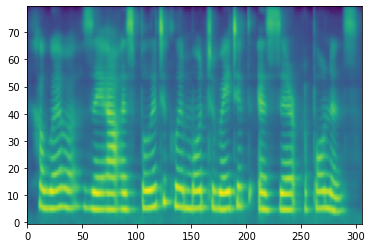

Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Mixing:False | Text: Breaking away from the illusion of market objectivity is the first step towards understanding capitalism.


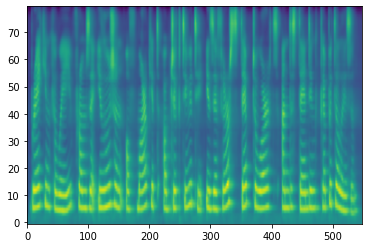

In [18]:
new_speaker_id = 6097
duration_mins = 5
mixing = False
original_speaker_id = "ljspeech"

last_ckpt = get_best_ckpt_from_last_run("./gdrive/MyDrive/", new_speaker_id, duration_mins, mixing, original_speaker_id)
print(last_ckpt)

spec_model = FastPitchModel.load_from_checkpoint(last_ckpt)
spec_model.eval().cuda()

# Only need to set speaker_id if there is more than one speaker
speaker_id = None
if mixing:
    speaker_id = 1

num_val = 2  # Number of validation samples
val_records = []
with open(f"{new_speaker_id}_manifest_dev_ns_all_local.json", "r") as f:
    for i, line in enumerate(f):
        val_records.append(json.loads(line))
        if len(val_records) >= num_val:
            break
            
for val_record in val_records:
    print("Real validation audio")
    ipd.display(ipd.Audio(val_record['audio_filepath'], rate=22050))
    print(f"SYNTHESIZED FOR -- Speaker: {new_speaker_id} | Dataset size: {duration_mins} mins | Mixing:{mixing} | Text: {val_record['text']}")
    spec, audio = infer(spec_model, vocoder, val_record['text'], speaker=speaker_id)
    ipd.display(ipd.Audio(audio, rate=22050))
    %matplotlib inline
    imshow(spec, origin="lower", aspect="auto")
    plt.show()

In [ ]:
spec, audio = infer(spec_model, vocoder, "You can write your text here", speaker=speaker_id)
ipd.display(ipd.Audio(audio, rate=22050))

In [20]:
!pip install FastAPI -q
!pip install uvicorn -q
!pip install fastapi nest-asyncio pyngrok uvicorn -q
!pip install noisereduce -q
import soundfile as sf
import noisereduce as nr
from scipy.io import wavfile

import sys
import os
import pandas as pd
import subprocess
import json
import codecs
import unidecode
import nest_asyncio
from pyngrok import ngrok
import uvicorn

is_initialized = False

from nemo.collections.tts.models import FastPitchModel
from nemo.collections.tts.models import HifiGanModel
from nemo.collections.nlp.models.machine_translation import MTEncDecModel

     |████████████████████████████████| 54 kB 1.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 10.9 MB 38.9 MB/s 
     |████████████████████████████████| 80 kB 7.6 MB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 58 kB 5.0 MB/s 
     |████████████████████████████████| 745 kB 5.2 MB/s 


In [21]:
synthesis_models = {
    'en': {
        'spec_gen': 'tts_en_fastpitch',
        'vocoder': 'tts_hifigan'
    }
}

translation_models = {
    'en': {
        'ru': 'nmt_en_ru_transformer6x6',
    },
    'ru': {
        'en': 'nmt_ru_en_transformer6x6',
    }
}

def models_init():
    global is_initialized
    if is_initialized:
        return True
    try:
        ckpt = "/content/gdrive/MyDrive/ljspeech_to_6097_no_mixing_5_mins/FastPitch/2022-05-13_18-13-53/checkpoints/FastPitch--v_loss=0.7351-epoch=24-last.ckpt"
        synthesis_models['en']['spec_gen'] = FastPitchModel.load_from_checkpoint(ckpt).eval().cuda()
        synthesis_models['en']['vocoder'] = HifiGanModel.from_pretrained('tts_hifigan').eval()
        translation_models['en']['ru'] = MTEncDecModel.from_pretrained(model_name="nmt_en_ru_transformer6x6")
        translation_models['ru']['en'] = MTEncDecModel.from_pretrained(model_name="nmt_ru_en_transformer6x6")
        is_initialized = True
        return 200
    except:
        return 404

def process_text(text: str) -> str:
    text = text.replace('&quest', '?')
    return text

def normalize_text(txt: str) -> str:
    valid_chars = (" ", "'", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u",
    "v", "w", "x", "y", "z")
    new_txt = unidecode.unidecode(txt.lower().strip())
    res_arr = []
    for c in new_txt:
        if c in valid_chars:
            res_arr.append(c)
        else:
            res_arr.append(' ')
    res = ''.join(res_arr).strip()
    return ' '.join(res.split())

In [24]:
from fastapi import FastAPI
from fastapi.responses import Response, FileResponse

app = FastAPI()

@app.get("/")
async def root():
    return {"message": "Translator for message exchange API is currently on."}

@app.get('/test_audio')
async def test_audio():
    return FileResponse('test_audio.wav')

@app.get("/init")
async def init():
    init_result = models_init()
    return {"status": "init_result"}

@app.get("/synthesize/{text}")
async def synthesize(text: str):
    pr_text = process_text(text)
    normalized_text = normalize_text(pr_text)
    try:
        with open(f'/audio/{normalized_text}.wav') as f:
            return FileResponse(f'audio/{normalized_text}.wav')
    except IOError:
        spec_gen = synthesis_models['en']['spec_gen']
        vocoder = synthesis_models['en']['vocoder']

        parsed = spec_gen.parse(normalized_text)
        spectrogram = spec_gen.generate_spectrogram(tokens=parsed)
        waveform = vocoder.convert_spectrogram_to_audio(spec=spectrogram)
        audio = waveform[0].cpu().detach().numpy().tolist()
        sf.write(f'audio/{normalized_text}.wav', audio, 22050)
        return FileResponse(f'audio/{normalized_text}.wav')

@app.get("/translate/{text}")
async def translate(text: str, src_lang: str = 'en', trg_lang: str = 'ru'):
    nmt_model = translation_models[src_lang][trg_lang]
    translation = nmt_model.translate(text, source_lang=src_lang, target_lang=trg_lang)
    return {"text": text, "translation": translation}

In [25]:
ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [69]


## Improving Speech Quality

We see that from fine-tuning FastPitch, we were able to generate audio in a male voice but the audio quality is not as good as we expect. We recommend two steps to improve audio quality:

* Finetuning HiFi-GAN
* Adding more data

**Note that both of these steps are outside the scope of the notebook due to the limited compute available on Colab, but the code is included below for you to use outside of this notebook.**

### Finetuning HiFi-GAN
From the synthesized samples, there might be audible audio crackling. To fix this, we need to finetune HiFi-GAN on the new speaker's data. HiFi-GAN shows improvement using **synthesized mel spectrograms**, so the first step is to generate mel spectrograms with our finetuned FastPitch model to use as input.

The code below uses our finetuned model to generate synthesized mels for the training set we have been using. You will also need to do the same for the validation set (code should be very similar, just with paths changed).

In [19]:
import json
import numpy as np
import torch
import soundfile as sf

from pathlib import Path

from nemo.collections.tts.torch.helpers import BetaBinomialInterpolator


def load_wav(audio_file):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
    return samples.transpose()

# Get records from the training manifest
manifest_path = "./6097_manifest_train_dur_5_mins_local.json"
records = []
with open(manifest_path, "r") as f:
    for i, line in enumerate(f):
        records.append(json.loads(line))

beta_binomial_interpolator = BetaBinomialInterpolator()
spec_model.eval()

device = spec_model.device

save_dir = Path("./6097_manifest_train_dur_5_mins_local_mels")
save_dir.mkdir(exist_ok=True, parents=True)

# Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
for i, r in enumerate(records):
    audio = load_wav(r["audio_filepath"])
    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)
    
    # Again, our finetuned FastPitch model doesn't use multiple speakers,
    # but we keep the code to support it here for reference
    if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
        speaker = torch.tensor([r['speaker']]).to(device)
    else:
        speaker = None
    
    with torch.no_grad():
        if "normalized_text" in r:
            text = spec_model.parse(r["normalized_text"], normalize=False)
        else:
            text = spec_model.parse(r['text'])
        
        text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)
    
        spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

        # Generate attention prior and spectrogram inputs for HiFi-GAN
        attn_prior = torch.from_numpy(
          beta_binomial_interpolator(spect_len.item(), text_len.item())
        ).unsqueeze(0).to(text.device)
            
        spectrogram = spec_model.forward(
          text=text, 
          input_lens=text_len, 
          spec=spect, 
          mel_lens=spect_len, 
          attn_prior=attn_prior,
          speaker=speaker,
        )[0]
        
        save_path = save_dir / f"mel_{i}.npy"
        np.save(save_path, spectrogram[0].to('cpu').numpy())
        r["mel_filepath"] = str(save_path)

hifigan_manifest_path = "hifigan_train_ft.json"
with open(hifigan_manifest_path, "w") as f:
    for r in records:
        f.write(json.dumps(r) + '\n')
# Please do the same for the validation json. Code is omitted.

[NeMo W 2022-05-13 19:26:59 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
      warnings.warn(problem)
    


We can then finetune hifigan similarly to fastpitch using NeMo's [hifigan_finetune.py](https://github.com/NVIDIA/NeMo/blob/main/examples/tts/hifigan_finetune.py) and [hifigan.yaml](https://github.com/NVIDIA/NeMo/blob/main/examples/tts/conf/hifigan/hifigan.yaml):

```bash
python examples/tts/hifigan_finetune.py \
--config-name=hifigan.yaml \
model.train_ds.dataloader_params.batch_size=32 \
model.max_steps=1000 \
model.optim.lr=0.0001 \
~model.optim.sched \
train_dataset=./hifigan_train_ft.json \
validation_datasets=./hifigan_val_ft.json \
exp_manager.exp_dir=hifigan_ft \
+init_from_nemo_model=tts_hifigan.nemo \
trainer.check_val_every_n_epoch=10 \
model.train_ds=hifigan_train_ft.json \
model.validation_ds=<your_hifigan_val_manifest>
```

Like when finetuning FastPitch, we lower the learning rate and get rid of the optimizer schedule for finetuning. You will need to create `<your_hifigan_val_manifest>` and the synthesized mels corresponding to it.

As mentioned, the above command is not runnable in Colab due to limited compute resources, but you are free to finetune HiFi-GAN on your own machines.

### Adding more data
We can add more data in two ways. They can be combined for the best effect:

* **Add more training data from the new speaker**

The entire notebook can be repeated from the top after a new JSON manifest is defined that includes the additional data. Modify your finetuning commands to point to the new manifest. Be sure to increase the number of steps as more data is added to both the FastPitch and HiFi-GAN finetuning.

We recommend **1000 steps per minute of audio for fastpitch and 500 steps per minute of audio for HiFi-GAN**.

* **Mix new speaker data with old speaker data**

We recommend finetuning FastPitch (but not HiFi-GAN) using both old speaker data (LJSpeech in this notebook) and the new speaker data. In this case, please modify the JSON manifests when finetuning FastPitch to include speaker information by adding a `speaker` field to each entry:

```
{"audio_filepath": "new_speaker.wav", "text": "sample", "duration": 2.6, "speaker": 1}
{"audio_filepath": "old_speaker.wav", "text": "LJSpeech sample", "duration": 2.6, "speaker": 0}
```

5 hours of data from the old speaker should be sufficient for training; it's up to you how much data from the old speaker to use in validation.

For the training manifest, since we likely have less data from the new speaker, we need to ensure that the model sees a similar amount of new data and old data. We can do this by repeating samples from the new speaker until we have an equivalent number of samples from the old and new speaker. For each sample from the old speaker, please add a sample from the new speaker in the .json.

As a toy example, if we use 4 samples of the old speaker and only 2 samples of the new speaker, we would want the order of samples in our manifest to look something like this:

```
old_speaker_sample_0
new_speaker_sample_0
old_speaker_sample_1
new_speaker_sample_1
old_speaker_sample_2
new_speaker_sample_0  # Start repeat of new speaker samples
old_speaker_sample_3
new_speaker_sample_1
```

Once the manifests are created, we can modify the FastPitch training command to point to the new training and validation JSON files.

We also need to update `model.n_speakers=1` to `model.n_speakers=2`, as well as update the `sup_data_types` specified in the config file to include `speaker_id` (`sup_data_types=[align_prior_matrix,pitch,speaker_id]`). Updating these two fields is very important--otherwise the model will not recognize that there is more than one speaker!

Ensure the pitch statistics correspond to the new speaker rather than the old speaker for best results.

**For HiFiGAN finetuning, the training should be done on the new speaker data.**